# Simple Expected Goal model using SVM

In [471]:
import pandas as pd
import numpy as np
import json

import seaborn as sn

import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

## Data Collection

In [63]:
#data from https://figshare.com/collections/Soccer_match_event_dataset/4415000/2

with open('data/events_Spain.json') as f:
    data = json.load(f)
    
with open('data/events_England.json') as f:
    data_2 = json.load(f)
    
with open('data/events_Germany.json') as f:
    data_3 = json.load(f)

In [297]:
df_events = pd.concat([pd.DataFrame(data), pd.DataFrame(data_2), pd.DataFrame(data_3)])
df_shots = df_events[df_events['subEventName'] == 'Shot']
shots_model = pd.DataFrame(columns = ['Goal','X','Y'])

In [299]:
df_events.shape

(1791216, 12)

## Feature Engineering

In [300]:
def compute_distance(x, y):
    x = x * 105/100
    y = y * 65/100
    return np.sqrt(x**2 + y**2)
    
    
def compute_angle(x, y):
    x = x * 105/100
    y = y * 65/100
    a = np.arctan(7.32 * x /(x**2 + y**2 - (7.32/2)**2))
    if a < 0:
        a = np.pi + a
    return a

In [301]:
#adapted from https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/3xGModel.py

for i, shot in df_shots.iterrows():
    
    header=0
    for shottags in shot['tags']:
        if shottags['id']==403:
            header=1

    #Only include non-headers        
    if not(header):        
        shots_model.at[i,'X']=100-shot['positions'][0]['x']
        shots_model.at[i,'Y']=shot['positions'][0]['y']
        shots_model.at[i,'C']=abs(shot['positions'][0]['y']-50)
        shots_model.at[i,'Distance'] = compute_distance(shots_model.at[i,'X'], shots_model.at[i,'C'])
        shots_model.at[i,'Angle'] = compute_angle(shots_model.at[i,'X'], shots_model.at[i,'C'])

        #Was it a goal
        shots_model.at[i,'Goal']=0
        for shottags in shot['tags']:
                #Tags contain that its a goal
                if shottags['id']==101:
                    shots_model.at[i,'Goal']=1

shots_model['Goal'] = pd.to_numeric(shots_model['Goal'])
shots_model.reset_index(drop=True, inplace = True)

## xG Plot

### Shots Position

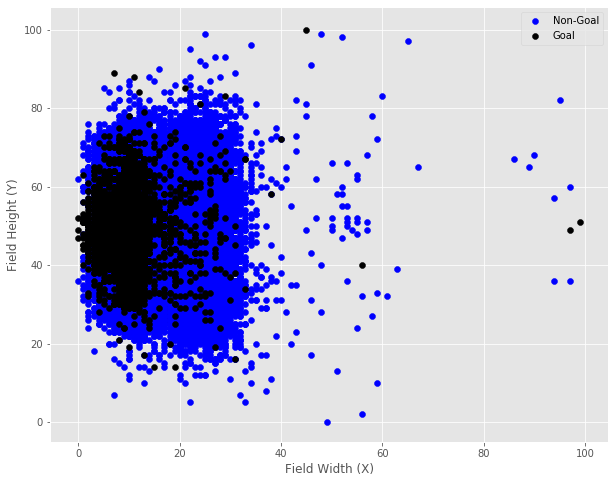

In [486]:
plt.figure(figsize=(10, 8))
plt.scatter(shots_model[shots_model['Goal'] == 0]['X'], shots_model[shots_model['Goal'] == 0]['Y'], label='Non-Goal', color='blue')
plt.scatter(shots_model[shots_model['Goal'] == 1]['X'], shots_model[shots_model['Goal'] == 1]['Y'], label='Goal', color='black')
plt.legend()
plt.xlabel('Field Width (X)')
plt.ylabel('Field Height (Y)')
plt.show()

### Goals Position model

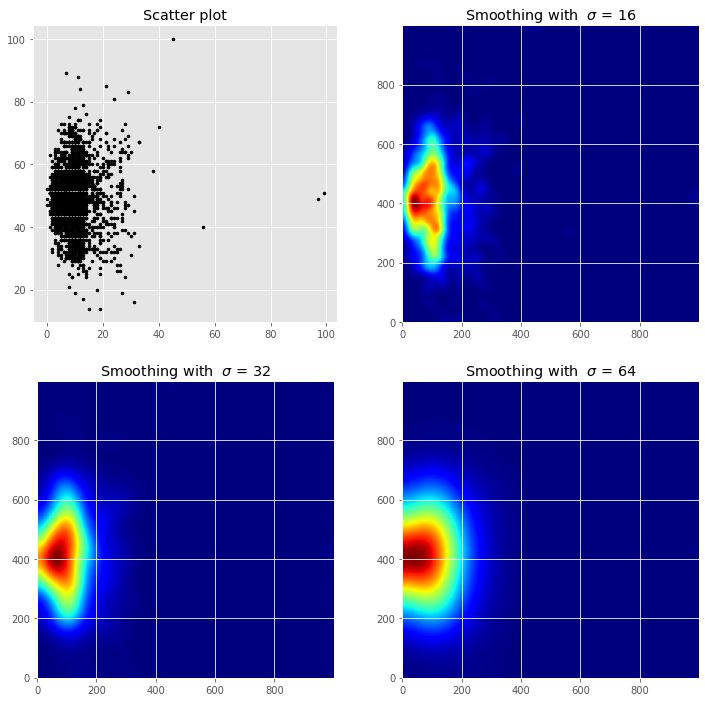

In [485]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent


fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Generate some test data
x = shots_model[shots_model['Goal'] == 1]['X']
y = shots_model[shots_model['Goal'] == 1]['Y']

sigmas = [0, 16, 32, 64]

for ax, s in zip(axs.flatten(), sigmas):
    
    if s == 0:
        ax.plot(x, y, 'k.', markersize=5)
        ax.set_title("Scatter plot")
    else:
        img, extent = myplot(x, y, s)
        ax.imshow(img, origin='lower', cmap=cm.jet)
        ax.set_title("Smoothing with  $\sigma$ = %d" % s)

plt.show()

## Data Split

### Undersampling of non-goals shots

In [458]:
# separate according to `label`
df_class_0 = shots_model[shots_model['Goal'] == 0]
df_class_1 = shots_model[shots_model['Goal'] == 1]

# sample only from class 0 quantity of rows of class 1
df_class_0_under = df_class_0.sample(len(df_class_1), random_state=5)
df_class_0_under = df_class_0.sample(len(df_class_1), random_state=5)


new_df = pd.concat([df_class_0_under, df_class_1], axis=0)

In [459]:
X_train, X_test, y_train, y_test = train_test_split(new_df[['X', 'Y', 'Angle', 'Distance']], new_df['Goal'], test_size=0.3, random_state=42)


## Fitting a SVM

In this experiment, the input will be the shooting positions (X, Y, distance and angle) and the target will be binary, indicating if the shot resulted in goal, or not.


GridSearch will be used for hyperparameter tuning

In [461]:
 
# defining parameter range 
param_grid = {'C': [0.1, 1],  
              'gamma': [1, 0.1, 0.001], 
              'kernel': ['rbf']}  
  
clf = GridSearchCV(SVC(probability=True), param_grid, refit = True)
clf.fit(X_train, y_train)


print(clf.best_params_)

{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}


## Results

In [462]:
y_pred = clf.predict(X_test)

In [473]:
print("Accuracy: ", round(accuracy_score(y_test, y_pred), 2))
print("Recall: ", round(recall_score(y_test, y_pred), 2))
print("Precision: ", round(precision_score(y_test, y_pred), 2))

Accuracy:  0.7
Recall:  0.72
Precision:  0.68


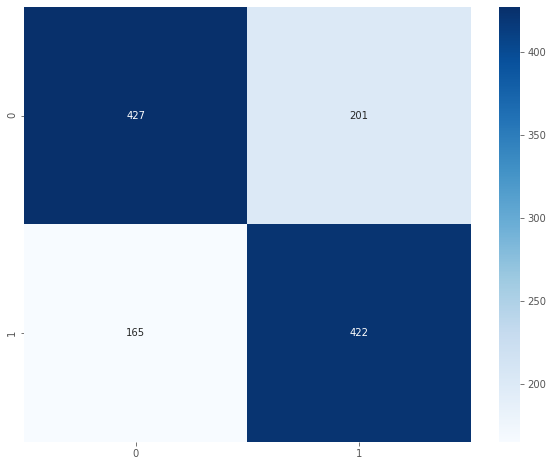

In [474]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (10,8))
sn.heatmap(cm, cmap='Blues', annot=True, fmt='g')
plt.show()

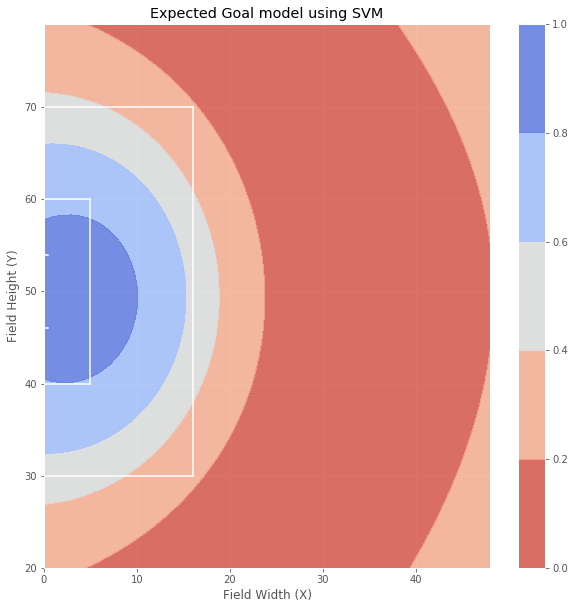

In [466]:
#Plot decision boudary using the entire field

X = shots_model[['X', 'Y', 'Angle', 'Distance']].values
y = shots_model['Goal']

def make_meshgrid(x, y, h=1):
    x_min, x_max = x.min(), x.max() - 50
    y_min, y_max = y.min() + 20, y.max() - 20
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    
    coords = np.c_[xx.ravel(), yy.ravel()]
    new_coords = []

    for v in coords:
        d = compute_distance(v[0], v[1]-50)
        a = compute_angle(v[0], v[1]-50)
        new_coords.append([v[0], v[1], a, d])
    
    new_coords = np.array(new_coords)

    Z = clf.predict_proba(new_coords)
    Z = Z[:, 0].reshape(xx.shape)
    out = ax.contourf(xx, yy, 1-Z, **params)
    return out, Z, new_coords



fig, ax = plt.subplots(figsize = (10, 10))
# title for the plots
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

out, Z, new_coords = plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm.reversed(), alpha=0.8, levels=4)

#ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlabel('Field Width (X)')
ax.set_ylabel('Field Height (Y)')
ax.set_title('Expected Goal model using SVM')


ax.plot(np.arange(0, 17), [30] * 17, 'w-')
ax.plot(np.arange(0, 17), [70] * 17, 'w-')
ax.plot([16] * 41, 30+np.arange(0, 41), 'w-')


ax.plot(np.arange(0, 6), [40] * 6, 'w-')
ax.plot(np.arange(0, 6), [60] * 6, 'w-')
ax.plot([5] * 21, 40+np.arange(0, 21), 'w-')

ax.plot([0, 0.5], [46] * 2, 'w-')
ax.plot([0, 0.5], [54] * 2, 'w-')
ax.plot([0] * 9, 46+np.arange(0, 9), 'w-')

fig.colorbar(out)


plt.show()

Analysing this simple xG model, we can see that the area closer to the defenders goal is the most probable location to score a goal (blue points).
The light red zones are the ones with the lower probability of scoring (as the distance to goal is also higher).

Each color is associadtes to a range of scoring probability, indicated on the side bar.

This was a very basic approach, considering only X, Y, distance to goal and angle positions.

In Future work, there are other interesting features to explore (tracking data is needed), namely:
- Goalkeeper position
- Defender position
- Pressure over the player